In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score
import random
import statistics
import skimage.io
import skimage.color
from numpy import unravel_index


In [ ]:
def transform(x):
  x=(x-np.mean(x,axis=0))/np.std(x,axis=0)
  #print(x.shape)
  return x

In [ ]:
# X, y = make_classification(n_samples=50000, n_features=20, n_informative=10, n_redundant=5,
#                            n_classes=2, weights=[0.7], class_sep=0.6, random_state=15)
b = np.load('/content/drive/MyDrive/pneumoniamnist.npz')
train_images=b['train_images']
val_images=b['val_images']
test_images=b['test_images']
Y_train=b['train_labels']
Y_test=b['val_labels']
Y_val=b['test_labels']
train_image=[]
test_image=[]
val_image=[]
for i in range(len(train_images)):
  train_image.append(skimage.color.rgb2gray(train_images[i]))
for i in range(len(test_images)):
  test_image.append(skimage.color.rgb2gray(test_images[i]))
for i in range(len(val_images)):
  val_image.append(skimage.color.rgb2gray(val_images[i]))
train_image=np.array(train_image)
test_image=np.array(test_image)
val_image=np.array(val_image)
X_train= train_image
X_val= test_image
X_test= val_image




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D 

In [ ]:
print(X_train[7].shape)

(28, 28)


In [ ]:
def convolution(w,I,size):
  m,n=I.shape
  k1=size
  I1=np.zeros((m+k1-1,n+k1-1))
  k1=k1//2
  I1[k1:m+k1,k1:n+k1]=I
  I=I1.copy()
  I1=np.zeros((m+size-1,n+size-1))
  for i in range(k1,m+k1):
    for j in range(k1,n+k1):
      p=I[i-k1:i+k1+1,j-k1:j+k1+1]
      #print(i,j,k1)
      I1[i][j]=np.sum(np.sum(p*w))
  return I1[1:m+1,1:n+1]


In [ ]:
def convolution_backprop(w,I,size):
  m,n=I.shape
  k1=size
  I1=np.zeros((m+k1-1,n+k1-1))
  k1=k1//2
  I1[k1:m+k1,k1:n+k1]=I
  I=I1.copy()
  m=m+size-1
  n=n+size-1
  k1=w.shape[0]
  w1=np.zeros((size,size))
  for i in range(0,size):
    for j in range(0,size):
      p=I[i:i+k1,j:j+k1]
      w1[i][j]=np.sum(np.sum(p*w))
  return w1


In [ ]:
def sigmoid(z):
  if z < 0:
    return 1 - 1/(1 + math.exp(z))
  else:
    return 1/(1 + math.exp(-z))


In [ ]:
def grad_sigmoid(z):
  return sigmoid(z)*(1-sigmoid(z))

In [ ]:
def getindices(F,size,stride): # reprersent stride in maxpooling
  indexes=[]
  relu_outputs=[]
  for c in range(len(F)):
    img=np.zeros(F[c].shape)
    m,n=img.shape
    for i in range(0,m,stride):
      for j in range(0,n,stride):
        p=F[c][i:i+size,j:j+size]
        indices=unravel_index(p.argmax(), p.shape)
        # print(indices,int(indices[0]),int(indices[1]),i,j,img.shape)
        # if(len(indices)>2):
        #   indices=indices[0]
        # print(indices,len(indices))
        img[i+int(indices[0])][j+int(indices[1])]=1
        relu_outputs.append(max(0,p.max())) # relu is implemented at once 
    indexes.append(img)
  relu_outputs.append(1)
  return indexes,np.array(relu_outputs)


In [ ]:
def softmax(l):
  k=np.exp(l)
  return k/np.sum(k)

In [ ]:
def onehotencoding(a):
  if a==0:
    return np.array([1,0])
  else:
    return np.array([0,1])

In [ ]:
def forward_prop(kernel_Weights,img,size,stride,w):
  F=[]
  for i in range(len(kernel_Weights)):
    F.append(convolution(kernel_Weights[i],img,size))
  maxpool_indices,relu_outputs=getindices(F,size,stride)
  n=len(relu_outputs)
  # w=np.random.randn((n+1,2))
  L=sigmoid(np.dot(w.T,relu_outputs))
  # for i in range(len(L)):
  #   L[i]=softmax(L[i])

  return F,maxpool_indices,L,relu_outputs

In [ ]:
def backward_prop(I,F,maxpool_indices,kernel_weights,w_lastlayer,L,relu_outputs,stride,size,Y):
  w_new=w_lastlayer.copy()
  l=L
  l1=relu_outputs
  W=w_lastlayer
  # k=(l-Y)*l*(1-l) # error at Last layer loss fun
  k=l-Y
  # print(k.shape)
  delta=k
  dj_w=np.zeros_like(W)
  m=len(W)
  # for i in range(0,m):
  #   for j in range(0,n):
  #     dj_w[i][j]=k[j]*l1[i]
  # for i in range(0,m):
  #   dj_w[i]=k*l1[i]
  # l1_n=np.reshape(l1,(m,1))
  # k_n=np.reshape(k,(n,1))
  # dj_w=k*l+W  # L2 regularizer
  k1=W.copy()
  k1[k1>0]=1
  k1[k1<0]=-1
  dj_w=dj_w=k*l+k #L1 regularizer
  lambda1=0.001
  W=W-(lambda1*dj_w)
  w_new=W
  error_relu_nodes=[0]*len(relu_outputs) # error at relu output nodes
  for i in range(len(relu_outputs)):
    a=0
    # for j in range(1):
    #   a+=k[j]*w_lastlayer[i]
    a=max(0,np.sum(k*w_lastlayer[i]))
    if a<=0:
      a=0
    error_relu_nodes[i]=a
  # now we need to find error of maxpool layer
  error_maxpool=maxpool_indices.copy()
  m1,n1=F[0].shape # size of image
  nodes_per_image=(m1//stride)*(n1//stride)
  for i in range(len(F)):
    nodes=error_relu_nodes[nodes_per_image*i:nodes_per_image*(i+1)]
    a=0
    for j in range(0,m1,stride):
      for y in range(0,n1,stride):
        error_maxpool[i][j:j+size,y:y+size]=nodes[a]*error_maxpool[i][j:j+size,y:y+size]
        a+=1
  # till now we calculated dj/dm  m= maxpool layer
  kernel_errors=[]
  for i in range(len(F)):
    X=error_maxpool[i]
    kernel_error=convolution_backprop(X,I,size)
    kernel_errors.append(kernel_error)
    kernel_weights[i]=kernel_weights[i]-(0.001)*(kernel_error)
  return kernel_weights,w_new


In [ ]:
def predict(kernel_weights,x,size,stride,w_lastlayer):
  F,maxpool_indices,y,relu_outputs=forward_prop(kernel_weights,x,size,stride,w_lastlayer)
  if(y>=0.5):
    max1=1
  else:
    max1=0
  return max1

In [ ]:
def predict_prob(kernel_weights,x,size,stride,w_lastlayer):
  ypred=[]
  for i in range(len(x)):
    F,maxpool_indices,y,relu_outputs=forward_prop(kernel_weights,x[i],size,stride,w_lastlayer)
    ypred.append(y)
  return ypred


In [ ]:
def logloss(y_true,y_pred):
  loss=np.sum(y_true*(np.log10(y_pred))+((np.ones_like(y_true)-y_true)*np.log10(np.ones_like(y_pred)-y_pred)))
  loss=-loss/len(y_true)
  #print(loss)
  return loss

In [ ]:
kernel_weights=[]
epochs=5
stride=2
size=5
filters=5
#img_size=28*28
n=(28//stride)*(28//stride)*filters+1
w_lastlayer=np.random.randn(n,1)
for i in range(filters):
  kernel_weights.append(np.random.randn(size,size))

trainingloss=[]
testloss=[]

for i in range(epochs):
  for j in range(len(X_train)):
    # Y = onehotencoding(Y_train[j])
    F,maxpool_indices,L,relu_outputs= forward_prop(kernel_weights,X_train[i],size,stride,w_lastlayer)
    k_weights,w_new = backward_prop(X_train[i],F,maxpool_indices,kernel_weights,w_lastlayer,L,relu_outputs,stride,size,Y_train[j])
    kernel_weights=k_weights.copy()
    w_lastlayer=w_new
    print(j,i)
  ypred=predict_prob(kernel_weights,X_train,size,stride,w_lastlayer)
  trainingloss.append(logloss(Y_train,ypred))
  ypred=predict_prob(kernel_weights,X_test,size,stride,w_lastlayer)
  testloss.append(logloss(Y_test,ypred))


Streaming output truncated to the last 5000 lines.
4416 3
4417 3
4418 3
4419 3
4420 3
4421 3
4422 3
4423 3
4424 3
4425 3
4426 3
4427 3
4428 3
4429 3
4430 3
4431 3
4432 3
4433 3
4434 3
4435 3
4436 3
4437 3
4438 3
4439 3
4440 3
4441 3
4442 3
4443 3
4444 3
4445 3
4446 3
4447 3
4448 3
4449 3
4450 3
4451 3
4452 3
4453 3
4454 3
4455 3
4456 3
4457 3
4458 3
4459 3
4460 3
4461 3
4462 3
4463 3
4464 3
4465 3
4466 3
4467 3
4468 3
4469 3
4470 3
4471 3
4472 3
4473 3
4474 3
4475 3
4476 3
4477 3
4478 3
4479 3
4480 3
4481 3
4482 3
4483 3
4484 3
4485 3
4486 3
4487 3
4488 3
4489 3
4490 3
4491 3
4492 3
4493 3
4494 3
4495 3
4496 3
4497 3
4498 3
4499 3
4500 3
4501 3
4502 3
4503 3
4504 3
4505 3
4506 3
4507 3
4508 3
4509 3
4510 3
4511 3
4512 3
4513 3
4514 3
4515 3
4516 3
4517 3
4518 3
4519 3
4520 3
4521 3
4522 3
4523 3
4524 3
4525 3
4526 3
4527 3
4528 3
4529 3
4530 3
4531 3
4532 3
4533 3
4534 3
4535 3
4536 3
4537 3
4538 3
4539 3
4540 3
4541 3
4542 3
4543 3
4544 3
4545 3
4546 3
4547 3
4548 3
4549 3
4550 3
4551

In [ ]:
def accuracy(y_test,y_pred):
  count =0
  for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
      count+=1
  accuracy = count*100/len(y_pred)
  return accuracy

In [ ]:
y_pred=[]
for i in range(len(X_test)):
  y_pred.append(predict(kernel_weights,X_test[i],size,stride,w_lastlayer)) #kernel_weights,X_train[i],size,stride,w_lastlayer
acc=accuracy(Y_test,y_pred)

In [ ]:
print(acc)

74.23664122137404


In [ ]:
y_pred=[]
for i in range(len(X_val)):
  y_pred.append(predict(kernel_weights,X_val[i],size,stride,w_lastlayer))
acc=accuracy(Y_val,y_pred)

In [ ]:
print(acc)

62.5


In [ ]:
y_pred=[]
for i in range(len(X_train)):
  y_pred.append(predict(kernel_weights,X_train[i],size,stride,w_lastlayer))
acc=accuracy(Y_train,y_pred)
print(acc)

74.21410365335599


In [ ]:
# import matplotlib.pyplot as plt
# epochs_list=[i for i in range(1,len(train_loss)+1)]
# fig,ax=plt.subplots()
# ax1=ax.twinx()
# ax.plot(epochs_list,train_loss,'r-')
# ax1.plot(epochs_list,test_loss,'b-')
# ax.set_xlabel("epochs")
# ax.set_ylabel("train loss")
# # ax1.set_ylabel("test loss")

Text(0, 0.5, 'train loss')

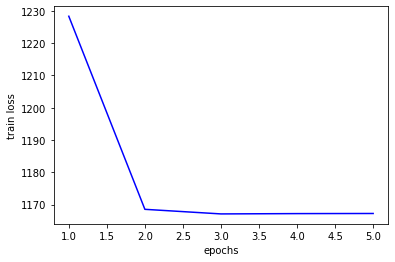

In [ ]:
import matplotlib.pyplot as plt
epochs_list=[i for i in range(1,len(trainingloss)+1)]
fig,ax=plt.subplots()
ax.plot(epochs_list,trainingloss,'b-')
ax.set_xlabel("epochs")
ax.set_ylabel("train loss")

Text(0, 0.5, 'test loss')

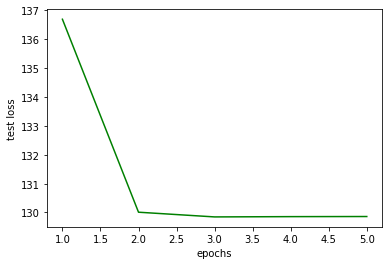

In [ ]:
import matplotlib.pyplot as plt
epochs_list=[i for i in range(1,len(testloss)+1)]
fig,ax=plt.subplots()
ax.plot(epochs_list,testloss,'g-')
ax.set_xlabel("epochs")
ax.set_ylabel("test loss")


In [ ]:
def get(y_test,y_pred):
  # # check len(y_pred) and len(y_test) matching are not:
  # if (len(y_test)!=len(y_pred)):
  #   print('Invalid lengths of y_test and y_pred\n')
  #   return;
  true_pos=0
  true_neg=0
  false_pos=0
  false_neg = 0

  for i in range(len(y_pred)):
    if(y_test[i]==1 and y_pred[i]==1):
      true_pos +=1
    elif(y_test[i]==0 and y_pred[i]==0):
      true_neg +=1
    elif(y_test[i]==0 and y_pred[i]==1):
      false_pos +=1
    elif(y_test[i]==1 and y_pred[i]==0):
      false_neg +=1
  
  return true_pos,true_neg,false_pos,false_neg

In [ ]:
def tpr(y_test,y_pred):
  tp,tn,fp,fn = get(y_test,y_pred)
  tpr = tp/(tp+fn)
  return tpr

def fpr(y_test,y_pred):
  tp,tn,fp,fn = get(y_test,y_pred)
  fpr = fp/(fp+tn)
  return fpr

In [ ]:
from sklearn import metrics
def ROC_AUC(y_test,y_pred):
  # tpr vs fpr plot is ROC
  tpr_list = []
  fpr_list=[]
  # y_pred = y_pred.sort()
  y_pred = np.array(y_pred)
  for thresh in np.arange(0,1.1,0.1):
    a = np.where(y_pred>=thresh,1,0)
    tpr_list.append(tpr(y_test,a))
    fpr_list.append(fpr(y_test,a))

  plt.plot(fpr_list,tpr_list,'b',lw=2)
  # plt.plot([0, 1], [0, 1], 'k-', lw=2)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.show()
  # print(tpr_list)
  # print(fpr_list)
  y_pred = np.where(y_pred>=0.5,1,0)
  #We use Trapezoidal rule to calculate the area under the curve and approximating the intergral  
  # auc = sum(np.trapz(tpr_list,fpr_list))+1
  return metrics.roc_auc_score(y_test, y_pred)

In [ ]:
def confusion_matrix(y_test,y_pred):
  m = np.unique(y_test)
  y_pred = np.array(y_pred)
  y_pred = np.where(y_pred>=0.5,1,0)
  tp,tn,fp,fn = get(y_test,y_pred)
  confusion_mat = np.array([tp,fp,fn,tn]).reshape(2,2)
  confusion_mat = pd.DataFrame(confusion_mat, columns = ['actual_pos','actual_neg'], index = ['pred_pos', 'pred_neg'])
  return confusion_mat

def f1_score(y_test,y_pred):
  #  # check len(y_pred) and len(y_test) matching are not:
  # if (len(y_test)!=len(y_pred)):
  #   print('Invalid lengths of y_test and y_pred\n')
  #   return;
  y_pred = np.array(y_pred)
  y_pred = np.where(y_pred>=0.5,1,0)
  true_pos=0
  true_neg=0
  false_pos=0
  false_neg = 0
  for i in range(len(y_pred)):
    if(y_test[i]==[1] and y_pred[i]==1):
      true_pos +=1
    elif(y_test[i]==[0] and y_pred[i]==0):
      true_neg +=1
    elif(y_test[i]==[0] and y_pred[i]==1):
      false_pos +=1
    elif(y_test[i]==[1] and y_pred[i]==0):
      false_neg +=1

  recall  = true_pos/(true_pos+false_neg)
  precision = true_pos/(true_pos+false_pos)
  f1_score = (2*precision*recall)/(precision+recall)

  return f1_score

In [ ]:
y_pred=[]
for i in range(len(X_test)):
  y_pred.append(predict(kernel_weights,X_test[i],size,stride,w_lastlayer)) #kernel_weights,X_train[i],size,stride,w_lastlayer
acc=accuracy(Y_test,y_pred)

In [ ]:
print(confusion_matrix(Y_test,y_pred))

          actual_pos  actual_neg
pred_pos         389         135
pred_neg           0           0


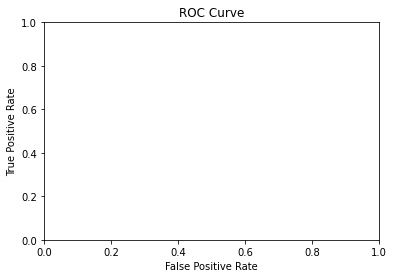

0.5


In [ ]:
print(ROC_AUC(Y_test,y_pred))

In [ ]:
print(f1_score(Y_test,y_pred))

0.8521358159912377
